#### Student name: Trung Kien Nguyen

Created_Date : 06/10/2018

Modified_Date: 26/10/2018


Environment: Python 3.6.0 and Anaconda 5.2.0 (64-bit)

Version: 2.1

Libraries used:
* pandas (for data frame, included in Anaconda Python 3.6) 
* numpy (included in Anaconda Python 3.6)
* matplotlib (include in Anconda Python 3.6)
* seaborn 0.9.0
* scipy 0.19
* sklearn 0.18.1
* pyshp 1.2.12: a library to process shapefile
* shapely 1.6.4: a library for manipulation and analysis of planar geometric objects



## Introduction

This projects comprises the execution of integrating several datasets into one single schema and finding and fixing all the possible error, followed by the comprehensive studying of how different methods of normalization/transformation effect to the "price".

There are 7 different datasets from the given files. Following is description of those data:
* Real estate Information *
```
real_state.json    : contain information about estate in json format
real_state.xml     : contain information about estate in xml format
hospitals.json     : contain basic information about hospital across Victoria state
shopingcenters.html: contain basic information about shoping centers across Victoria state
supermarkets.xlsx  : contain basic information about supermarket ( mostly Coles and Woolworths across Victoria state )
```

* GTFS Melbourne Train Information*
```
agency   : Contain basic information about public transport provider in Melbourne ( in this data is PTV )
calendar : The calendar table defines service patterns that operate recurrently such as, for example, every weekday. Service patterns that don't repeat such as for a one-time special event will be defined in the calendar_dates table.
calendar_date: 
routes   : The routes table identifies distinct routes. This is to be distinguished from distinct routings, several of which may belong to a single route.
shapes   : Rules for drawing lines on a map to represent a transit organization's routes.
stop_times: contain information of each time the train stop at specific station
stops    : The stops table defines the geographic locations of each and every actual stop or station in the transit system as well as, and optionally, some of the amenities associated with those stops.
trips    : Provide the specific information of particular trips
```
More information about the GTFS data: https://en.wikipedia.org/wiki/General_Transit_Feed_Specification


* Victoria Suburb Boundary:
```
VIC_LOCALITY_POLYGON_shp.dbf
VIC_LOCALITY_POLYGON_shp.prj
VIC_LOCALITY_POLYGON_shp.shp
VIC_LOCALITY_POLYGON_shp.shx 
```
More information about shapefile: https://en.wikipedia.org/wiki/Shapefile




The output of data is: __`solution.csv`__ 

This document breaks down the data wrangling tasks into the following steps:

# Task 1: Data Integration

This task required to integrate these 7 datasets into one by following given schema


## 1. Loading Datasets
Following is libraries that we are going to use through pre-processing step.

In [1]:
import pandas as pd
import numpy as np

import math
from datetime import datetime
import calendar

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### 1.1 Loading Estate Data.

In this section, we will load the estate data in json and xml format and see what is inside the data as well as the number of features, number of records.

First, load real_estate.json and quickly take a look on the data

In [2]:
df_estate_json = pd.read_json('real_state.json',precise_float=True)
df_estate_json.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year
0,18 Arthur Street,1.0,3.0,-37.790287,144.851058,1.0,3910000.0,5557.0,house,2013.0
1,16 Emmaline Crescent,2.0,3.0,-37.997261,145.149779,2.0,6200000.0,79731.0,house,2012.0
2,17 Union Street,1.0,3.0,-37.789166,144.842816,2.0,6960000.0,6281.0,house,2010.0
3,269 Mansfield Street,1.0,4.0,-37.758343,145.021371,0.0,7950000.0,31038.0,house,2016.0
4,5 Edmends Street,1.0,2.0,-37.765106,144.964796,1.0,14560000.0,21307.0,house,2014.0


The data contains 10 attributes, including:
```
property_id   : id of estate
addr_street   : the street name of the estate
bathrooms     : number of bathroom of the estate
bedrooms      : number of bedrooms of the estate
lat           : latitude of the estate
lng           : longitude of the estate
parking_space : number of parking space of estate
price         : how much does it cost to buy this house
property_type : determine whether the estate is a house or apartments and so on
year          : the year of selling the estate
```

Let's check whether is any null records


In [3]:
df_estate_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 10 columns):
addr_street      1007 non-null object
bathrooms        1007 non-null float64
bedrooms         1007 non-null float64
lat              1007 non-null float64
lng              1007 non-null float64
parking_space    1007 non-null float64
price            1007 non-null float64
property_id      1007 non-null float64
property_type    1007 non-null object
year             1007 non-null float64
dtypes: float64(8), object(2)
memory usage: 79.0+ KB


In [4]:
df_estate_json[df_estate_json['property_id'].isnull()]

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year
435,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
468,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
726,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN


There are 1010 records in total but there are also three records that are completely null. Thus, we can simply remove all the null records.

In [5]:
df_estate_json = df_estate_json.dropna().reset_index().drop(["index"],axis=1)

Next, we will check the duplication

In [6]:
df_estate_json[df_estate_json['property_id'].duplicated(keep=False)]

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year
551,43 Everard Street,2.0,3.0,-37.699226,144.938431,3.0,4260000.0,17248.0,house,2008.0
604,43 Everard Street,2.0,3.0,-37.699226,144.938431,3.0,4260000.0,17248.0,house,2008.0


Two duplicated rows inside the data, remove all the duplication but keep one.

In [7]:
df_estate_json = df_estate_json.drop_duplicates(keep='last').reset_index().drop(['index'],axis=1)

In [8]:
df_estate_json.shape

(1006, 10)

Now, we are going to load the estate in xml format. Unlike json format, xml can not be easy to be parsed by pandas library. The xml file could be structured in different way in term of tag, value and attribute. 

Therefore, we need to understand how the given xml was constructed

In [9]:
xml_data = None
with open("real_state.xml") as f:
    xml_data = f.read()
xml_data

'<?xml version="1.0" encoding="UTF-8" ?><root><bathrooms type="dict"><n80940 type="number">2.0</n80940><n22506 type="number">1.0</n22506><n19493 type="number">1.0</n19493><n55619 type="number">2.0</n55619><n54603 type="number">1.0</n54603><n27636 type="number">2.0</n27636><n58387 type="number">2.0</n58387><n73395 type="number">1.0</n73395><n19714 type="number">2.0</n19714><n63524 type="number">2.0</n63524><n48299 type="number">1.0</n48299><n21561 type="number">1.0</n21561><n47124 type="number">2.0</n47124><n19424 type="number">1.0</n19424><n11980 type="number">2.0</n11980><n4784 type="number">1.0</n4784><n78852 type="number">1.0</n78852><n45064 type="number">1.0</n45064><n21764 type="number">1.0</n21764><n55290 type="number">1.0</n55290><n7306 type="number">1.0</n7306><n45089 type="number">2.0</n45089><n9285 type="number">2.0</n9285><n54698 type="number">3.0</n54698><n18559 type="number">1.0</n18559><n96472 type="number">2.0</n96472><n4142 type="number">1.0</n4142><n20961 type="number"

From the output above, it can be seen that each child of the root tag contains the attributes which are the features (columns of dataframe) of the data such as: bathrooms, bedrooms, parking_space, price and so on.

Each root's child element contains an array of values of that child.

For example:
```
root's child tag: bathroom
<bathrooms type="dict">
   <n80940 type="number">2.0</n80940>
   <n22506 type="number">1.0</n22506>
   <n19493 type="number">1.0</n19493>
   <n55619 type="number">2.0</n55619>
   <n54603 type="number">1.0</n54603>
   <n27636 type="number">2.0</n27636>
   <n58387 type="number">2.0</n58387>
   ...................
</bathrooms>
tag name: batrooms which is a feature of data
<n80940 type="number">2.0</n80940>: mean the estate that have id = 80940 have 2 bathrooms.
type="number" is a tag attribute indicate the value of the tag is in number format.
```

The similarity witness for all the other child of the root such as bedrooms, parking_space, lat, lng, price and so on.

In order to form xml data into dataframe, we will read each single child of the root, including __id__ and the __value__ and form those data into one dataframe.

The idea is we will create several dataframe, each dataframe contain each feature of the estate and each dataframe will consist of __id__ of estate and the __value__ of the feature of that id.

For example, the dataframe of the bathroom will look like this:
```
df_bathrooms:
 ----------------------------- 
| property_id  |  bath_rooms |
| 80940        |  2.0        |
| 22506        |  1.0        | 
| 19493        |  1.0        |
| 55619        |  2.0        |
| 54603        |  1.0        |
| 27636        |  2.0        |
 -----------------------------
```

The similarity for other features.

Finally, we will merge all the dataframe into one dataframe based on the __property_id__ attribute.

First, let's load the data by using ElementTree which is a library to handle xml format of Python

In [10]:
import xml.etree.ElementTree as ET

xml_content = ET.parse("real_state.xml")

Now, we will create an array to contain several dataframe. 

In [11]:
df_arr = []

For each element of the root, we will get the its child name which is a feature name.

For each child, we will get each child tag, which is __id__ and child value.

Let's go into code

In [12]:
# make a loop to iterate all the elements of the root
for node in xml_content.getroot():
    # get the name of child
    column_name = node.tag
    # make a loop to get id for each property.
    # There are some id that starts with 'n', we will remove it and take the rest
    # make a list comprehension for short, thank to Python
    property_id = [child.tag[1:] if child.tag.startswith("n") else child.tag for child in node ]
    # do the same thing for getting the values
    values = [child.text for child in node]
    # form the data into dataframe with property_id and column_name features
    df = pd.DataFrame(data={"_property_id":property_id,column_name:values})
    # add the dataframe into array of dataframe
    df_arr.append(df)


By this point, we will reduce all the dataframe from the array to get single dataframe of estate. 

The reduce phases will based on property_id.

In [13]:
from functools import reduce

df_estate_xml = None
df_estate_xml = reduce(lambda left,right: left.merge(right,on="_property_id",how="outer"),df_arr)

#drop _property_id cause we are already have property_id feature
df_estate_xml.drop(["_property_id"],axis=1,inplace=True)
df_estate_xml

,bathrooms,price,bedrooms,parking_space,year,lat,lng,property_type,addr_street,property_id
0,2.0,5432000.0,3.0,2.0,2014.0,-37.968024,145.223352,house,197 Stud Road,80940.0
1,1.0,8232000.0,2.0,0.0,2011.0,-37.74133,144.956195,house,29 Vincent Street,22506.0
2,1.0,3835000.0,3.0,1.0,2014.0,-37.658385,144.93002,house,8 Nareen Avenue,19493.0
3,2.0,24830000.0,4.0,2.0,2016.0,-37.847339,145.095193,house,4 Braeside Avenue,55619.0
4,1.0,12120000.0,3.0,1.0,2009.0,-37.81683731,145.0206604,house,53 Mason Street,54603.0
5,2.0,5057000.0,3.0,2.0,2016.0,-37.602233,144.913391,house,7 Sage Hills Place,27636.0
6,2.0,8000000.0,3.0,2.0,2014.0,-37.815681,145.141379,house,9 Tara Avenue,58387.0
7,1.0,5000000.0,3.0,2.0,2010.0,-37.872219,145.283261,house,28 Aubrey Grove,73395.0
8,2.0,7360000.0,3.0,2.0,2015.0,-37.672845,144.889074,house,34 The Crest,19714.0
9,2.0,9350000.0,4.0,2.0,2014.0,-37.793242,145.296572,house,14 Allendale Road,63524.0


df_estate_xml look pretty much the same to the df_estate_json, the difference is the order of the columns, we will fix it later when we join two dataframe together.

For now, let's going to see whether is there any null data we've been read from xml file ?

In [14]:
df_estate_xml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1006 entries, 0 to 1005
Data columns (total 10 columns):
bathrooms        1006 non-null object
price            1006 non-null object
bedrooms         1006 non-null object
parking_space    1006 non-null object
year             1006 non-null object
lat              1006 non-null object
lng              1006 non-null object
property_type    1006 non-null object
addr_street      1006 non-null object
property_id      1006 non-null object
dtypes: object(10)
memory usage: 86.5+ KB


There is no null records of xml file, go to check for the duplication 

In [15]:
df_estate_xml[df_estate_xml.duplicated()]

,bathrooms,price,bedrooms,parking_space,year,lat,lng,property_type,addr_street,property_id
437,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
674,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
940,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


Interestingly, we've been check the null data before, the reason we did not find any null data because all the null records are characteried by the string of 'nan'. Let's remove all these error.

In [16]:
df_estate_xml = df_estate_xml.drop_duplicates()

We've been seen that the duplicated happend because there are some null of value, however it is characterized by the string of 'nan'. By that reason, we will going to check to the property_id

In [17]:
df_estate_xml[df_estate_xml['property_id'].str.lower() == 'nan']

,bathrooms,price,bedrooms,parking_space,year,lat,lng,property_type,addr_street,property_id
433,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


Remove the 'nan' out of the data

In [18]:
df_estate_xml = df_estate_xml[df_estate_xml['property_id'] != 'nan']
df_estate_xml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1002 entries, 0 to 1005
Data columns (total 10 columns):
bathrooms        1002 non-null object
price            1002 non-null object
bedrooms         1002 non-null object
parking_space    1002 non-null object
year             1002 non-null object
lat              1002 non-null object
lng              1002 non-null object
property_type    1002 non-null object
addr_street      1002 non-null object
property_id      1002 non-null object
dtypes: object(10)
memory usage: 86.1+ KB


By now we can safely concatenate two data frame of estate ( one estate data frame from json format and one estate data frame from xml format ). However, before going to join two dataframe, we will convert each features from df_estate_xml dataframe to the similar format of df_estate_json.
By now, the format of each columns of df_estate_json look like this:
```
addr_street      1007 non-null object
bathrooms        1007 non-null float64
bedrooms         1007 non-null float64
lat              1007 non-null float64
lng              1007 non-null float64
parking_space    1007 non-null float64
price            1007 non-null float64
property_id      1007 non-null float64
property_type    1007 non-null object
year             1007 non-null float64
```

and the format of each columns of df_estate_xml look like this:
```
bathrooms        1002 non-null object
price            1002 non-null object
bedrooms         1002 non-null object
parking_space    1002 non-null object
year             1002 non-null object
lat              1002 non-null object
lng              1002 non-null object
property_type    1002 non-null object
addr_street      1002 non-null object
property_id      1002 non-null object
```

Let's go to modify

In [19]:
df_estate_xml['bathrooms'] = df_estate_xml['bathrooms'].astype(np.float64)
df_estate_xml['price'] = df_estate_xml['price'].astype(np.float64)
df_estate_xml['bedrooms'] = df_estate_xml['bedrooms'].astype(np.float64)
df_estate_xml['parking_space'] = df_estate_xml['parking_space'].astype(np.float64)
df_estate_xml['property_id'] = df_estate_xml['property_id'].astype(np.float64)
df_estate_xml['year'] = df_estate_xml['year'].astype(np.float64)
df_estate_xml['lat'] = df_estate_xml['lat'].astype(np.float64)
df_estate_xml['lng'] = df_estate_xml['lng'].astype(np.float64)

In order to make concatenation, we first re-index the columns name of both the data frame to have the consistence

In [20]:
columns = ["property_id","lat","lng","addr_street","price","property_type","year","bedrooms","bathrooms","parking_space"]
df_estate_json = df_estate_json.reindex(columns=columns)
df_estate_xml = df_estate_xml.reindex(columns=columns)

Now, concatening two dataframe together

In [21]:
df_estate = pd.concat([df_estate_json,df_estate_xml])
df_estate = df_estate.reset_index().drop(['index'],axis=1)
df_estate

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
0,5557.0,-37.790287,144.851058,18 Arthur Street,3910000.0,house,2013.0,3.0,1.0,1.0
1,79731.0,-37.997261,145.149779,16 Emmaline Crescent,6200000.0,house,2012.0,3.0,2.0,2.0
2,6281.0,-37.789166,144.842816,17 Union Street,6960000.0,house,2010.0,3.0,1.0,2.0
3,31038.0,-37.758343,145.021371,269 Mansfield Street,7950000.0,house,2016.0,4.0,1.0,0.0
4,21307.0,-37.765106,144.964796,5 Edmends Street,14560000.0,house,2014.0,2.0,1.0,1.0
5,56807.0,-37.848610,145.109491,6 Elgar Road,4995000.0,house,2016.0,3.0,1.0,2.0
6,86453.0,-37.911141,144.989884,27 Normanby Street,6303000.0,house,2013.0,4.0,2.0,3.0
7,7690.0,-37.776264,144.799805,1 Glinden Avenue,4680000.0,house,2011.0,3.0,1.0,1.0
8,89501.0,-37.948786,145.015447,39 Hobson Street,9630000.0,house,2014.0,3.0,2.0,2.0
9,33372.0,-37.696310,145.021222,1 Keon Parade,5040000.0,house,2014.0,4.0,2.0,1.0


In [22]:
df_estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2008 entries, 0 to 2007
Data columns (total 10 columns):
property_id      2008 non-null float64
lat              2008 non-null float64
lng              2008 non-null float64
addr_street      2008 non-null object
price            2008 non-null float64
property_type    2008 non-null object
year             2008 non-null float64
bedrooms         2008 non-null float64
bathrooms        2008 non-null float64
parking_space    2008 non-null float64
dtypes: float64(8), object(2)
memory usage: 157.0+ KB


We also need to check are any duplicated records between those dataframe

In [23]:
df_estate[df_estate.duplicated()].shape

(37, 10)

Simply remove duplicated rows.

In [24]:
df_estate = df_estate.drop_duplicates(keep='first')
df_estate = df_estate.reset_index().drop(['index'],axis=1)

We've been read, cleaned the estate data from json and xml file.

By now, we are going to get the nearest facilities, including hospital, train station, supermarket and shopping center.

The following section attempt to load the data from of facilities from different format and then for each estate, we will get the closest facilities from particular estate and distance between them.

### 1.2 Loading Facilities Datasets.

Firstly, load the hospital datasets in the json format.

In [25]:
df_hospital = pd.read_json("hospitals.json")
df_hospital

,id,lat,lng,name
0,hospital_001,-37.990622,145.072836,Como Private Hospital
1,hospital_002,-37.855469,145.268183,Mountain District Private Hospital
2,hospital_003,-37.792230,144.889128,Western Hospital
3,hospital_004,-37.756042,145.061896,Mercy Hospital for Women
4,hospital_005,-37.760623,144.815624,Sunshine Hospital
5,hospital_006,-36.359274,145.410832,Shepparton Private Hospital
6,hospital_007,-37.774573,144.923973,Ascot Vale Road Specialist Rooms
7,hospital_008,-37.849467,145.226801,Knox Private Hospital
8,hospital_009,-37.869801,145.003096,Masada Private Hospital
9,hospital_010,-37.810454,145.194100,Mitcham Private Hospital


Secondly, load the supermarket datasets in the excel format

In [26]:
df_supermarket = pd.read_excel("29057957/supermarkets.xlsx")
df_supermarket

,id,lat,lng,type
0,S_001,-37.883978,144.735287,Woolworths
1,S_002,-41.161591,147.514797,Woolworths
2,S_003,-37.984078,145.077167,Woolworths
3,S_004,-37.707023,144.938740,Woolworths
4,S_005,-37.597670,144.938413,Woolworths
5,S_006,-38.101859,145.184101,Woolworths
6,S_007,-37.867486,144.742849,Woolworths
7,S_008,-37.889410,145.293758,Woolworths
8,S_009,-37.915287,144.995748,Woolworths
9,S_010,-37.922149,145.083448,Woolworths


Finally, load the shopingcenters dataset in the html format

In [27]:
df_shoping = pd.read_html('shopingcenters.html')
df_shoping = df_shoping[0].drop(['Unnamed: 0'],axis=1)
df_shoping

,sc_id,lat,lng
0,SC_001,-37.767915,145.041790
1,SC_002,-37.819375,145.171472
2,SC_003,-37.971131,145.089065
3,SC_004,-35.280406,149.132550
4,SC_005,-37.574572,144.920451
5,SC_006,-38.355943,144.907320
6,SC_007,-37.812680,144.962905
7,SC_008,-37.811846,144.969834
8,SC_009,-37.765650,145.091914
9,SC_010,-37.714111,144.886988


We've loaded all the basic data for schema, we will leave the GTFS Melbourne Train as well as Victoria Suburb dataset until in the next following sections. At this point, we are going to get the closet supermarket, hospital and shoping centers for each estate by using latitude and longitude.

## 2. Finding Nearest Facilities.

In this part, we will calculate the nearest facilities (e.g: hospital, supermarket and shoping centers) for each estate from the given data.

Before going further, let reminded that the radius of earth is 6378km. In the next script, we will define a distance function, which is used to get the distance between origin and destination based on latitude and longitude.

After that, the function get_nearest_facilities used to get the closest of speicific factilities for each estate.

In [28]:
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6378  # km
    
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    
    #convert to meter and return.
    return d*1000

def get_nearest_facilities(lat,lng, df_facilities):
    df_fa_lat_lng = df_facilities[['lat','lng']]
    value = df_fa_lat_lng.apply(lambda x: distance((lat,lng),(x[0],x[1])), axis=1)
    value = np.asarray(value)
    return (df_facilities.iloc[value.argmin()][0],value.min())


In [29]:
df_estate.head()

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
0,5557.0,-37.790287,144.851058,18 Arthur Street,3910000.0,house,2013.0,3.0,1.0,1.0
1,79731.0,-37.997261,145.149779,16 Emmaline Crescent,6200000.0,house,2012.0,3.0,2.0,2.0
2,6281.0,-37.789166,144.842816,17 Union Street,6960000.0,house,2010.0,3.0,1.0,2.0
3,31038.0,-37.758343,145.021371,269 Mansfield Street,7950000.0,house,2016.0,4.0,1.0,0.0
4,21307.0,-37.765106,144.964796,5 Edmends Street,14560000.0,house,2014.0,2.0,1.0,1.0


In [30]:
# getting nearest shopping center
results = df_estate.apply(lambda x: get_nearest_facilities(x[1],x[2],df_shoping),axis=1)
df_result = pd.DataFrame(data=list(results),columns=['id','distance'])
df_estate["shopping_center_id"] = df_result['id']
df_estate['distance_to_sc'] = df_result['distance']

In [31]:
# getting nearest hospital
results = df_estate.apply(lambda x: get_nearest_facilities(x[1],x[2],df_hospital),axis=1)
df_result = pd.DataFrame(data=list(results),columns=['id','distance'])
df_estate["hospital_id"] = df_result['id']
df_estate['distance_to_hospital'] = df_result['distance']

In [32]:
# getting nearest supermarket
results = df_estate.apply(lambda x: get_nearest_facilities(x[1],x[2],df_supermarket),axis=1)
df_result = pd.DataFrame(data=list(results),columns=['id','distance'])
df_estate["supermarket_id"] = df_result['id']
df_estate['distance_to_supermaket'] = df_result['distance']

At this time, we got almost of the facilities for each estate except nearest station.

In the next section, we will go to get the suburb first, and then get with the nearest station later.

## 3. Finding the Suburb

In order to get the suburb, we wil deal with the shapefile.

Shapefile in generally is format is a popular geospatial vector data format for geographic information system (GIS) software. The three mandatory files have filename extensions .shp, .shx, and .dbf which is.
```
Mandatory files 
.shp — shape format; the feature geometry itself
.shx — shape index format; a positional index of the feature geometry to allow seeking forwards and backwards quickly
.dbf — attribute format; columnar attributes for each shape, in dBase IV format

```

More information about shapefile: https://en.wikipedia.org/wiki/Shapefile

In order to get suburb for each estate, we need to know that each suburb is form by a polygon. Each polygon is shaped by a list of couple of latitude and longitude. Our job is to determine what is the suburb from the given latitude and longitude that each estate belong to. 

First, let's read the shapefile using shapefile library.

In [33]:
import shapefile

sf = shapefile.Reader("vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp")
shapes = sf.shapes()
shapes_detail = sf.records()
num_of_shape = sf.numRecords

__shapes__ is a object that contains the list of couple of latitude and longitude of each suburb while the __shapes_detail__ contains information of that suburb, such as name of suburb.

Let's see the first data of the shapes and shapes_detail

In [34]:
shapes[0].points

[(141.74552399, -35.07228701),
 (141.74552471, -35.07201624),
 (141.74748471, -35.06367123),
 (141.74909525, -35.05681288),
 (141.74917403, -35.05647197),
 (141.75887404, -35.05225699),
 (141.77005396, -35.04914101),
 (141.77057401, -35.04899703),
 (141.76823304, -35.04349501),
 (141.76757096, -35.04270197),
 (141.76709398, -35.03982199),
 (141.76544215, -35.03808514),
 (141.76547768, -35.03782986),
 (141.76408494, -35.03523684),
 (141.76398063, -35.03505673),
 (141.76387633, -35.03487661),
 (141.75923139, -35.02629546),
 (141.77479178, -35.02631526),
 (141.77477947, -35.02789069),
 (141.79121543, -35.02632192),
 (141.79143466, -35.02629765),
 (141.79143596, -35.04874003),
 (141.79351097, -35.04729598),
 (141.79428796, -35.04709498),
 (141.79636183, -35.04970131),
 (141.79864596, -35.05329199),
 (141.79782903, -35.05527899),
 (141.79795996, -35.056872),
 (141.79605705, -35.05895805),
 (141.79644599, -35.06340397),
 (141.79743197, -35.06573301),
 (141.79758596, -35.06874604),
 (141.7995

The data includes the list of tuple of longitude and latitude with the longitude is the first element of the tuple and latitude is second element of the tuple. 

Let's see what is the shape of those coordinate

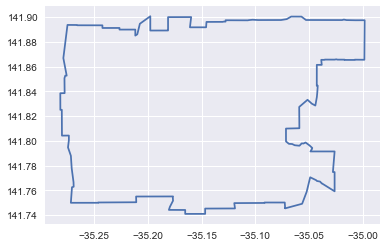

In [35]:
x = [x[1] for x in shapes[0].points]
y = [y[0] for y in shapes[0].points]
plt.plot(x,y)

Our goal is to determine whether a given point belong to a polygon or not. The given point here is the coordinate (latitude and longitude) of the estate. 

What's detail of this this polygon?

In [36]:
shapes_detail[0]

['6670',
 datetime.date(2011, 8, 31),
 None,
 'VIC2615',
 datetime.date(2012, 4, 27),
 None,
 'UNDERBOOL',
 '',
 '',
 'G',
 None,
 '2']

It can be seen that the polygons above describes the shape of UNDERBOOL suburb.
Now, we can draw a the shape of the suburb of Victoria state, the script belong will show us the how does the shape of each suburb of Victoria look like

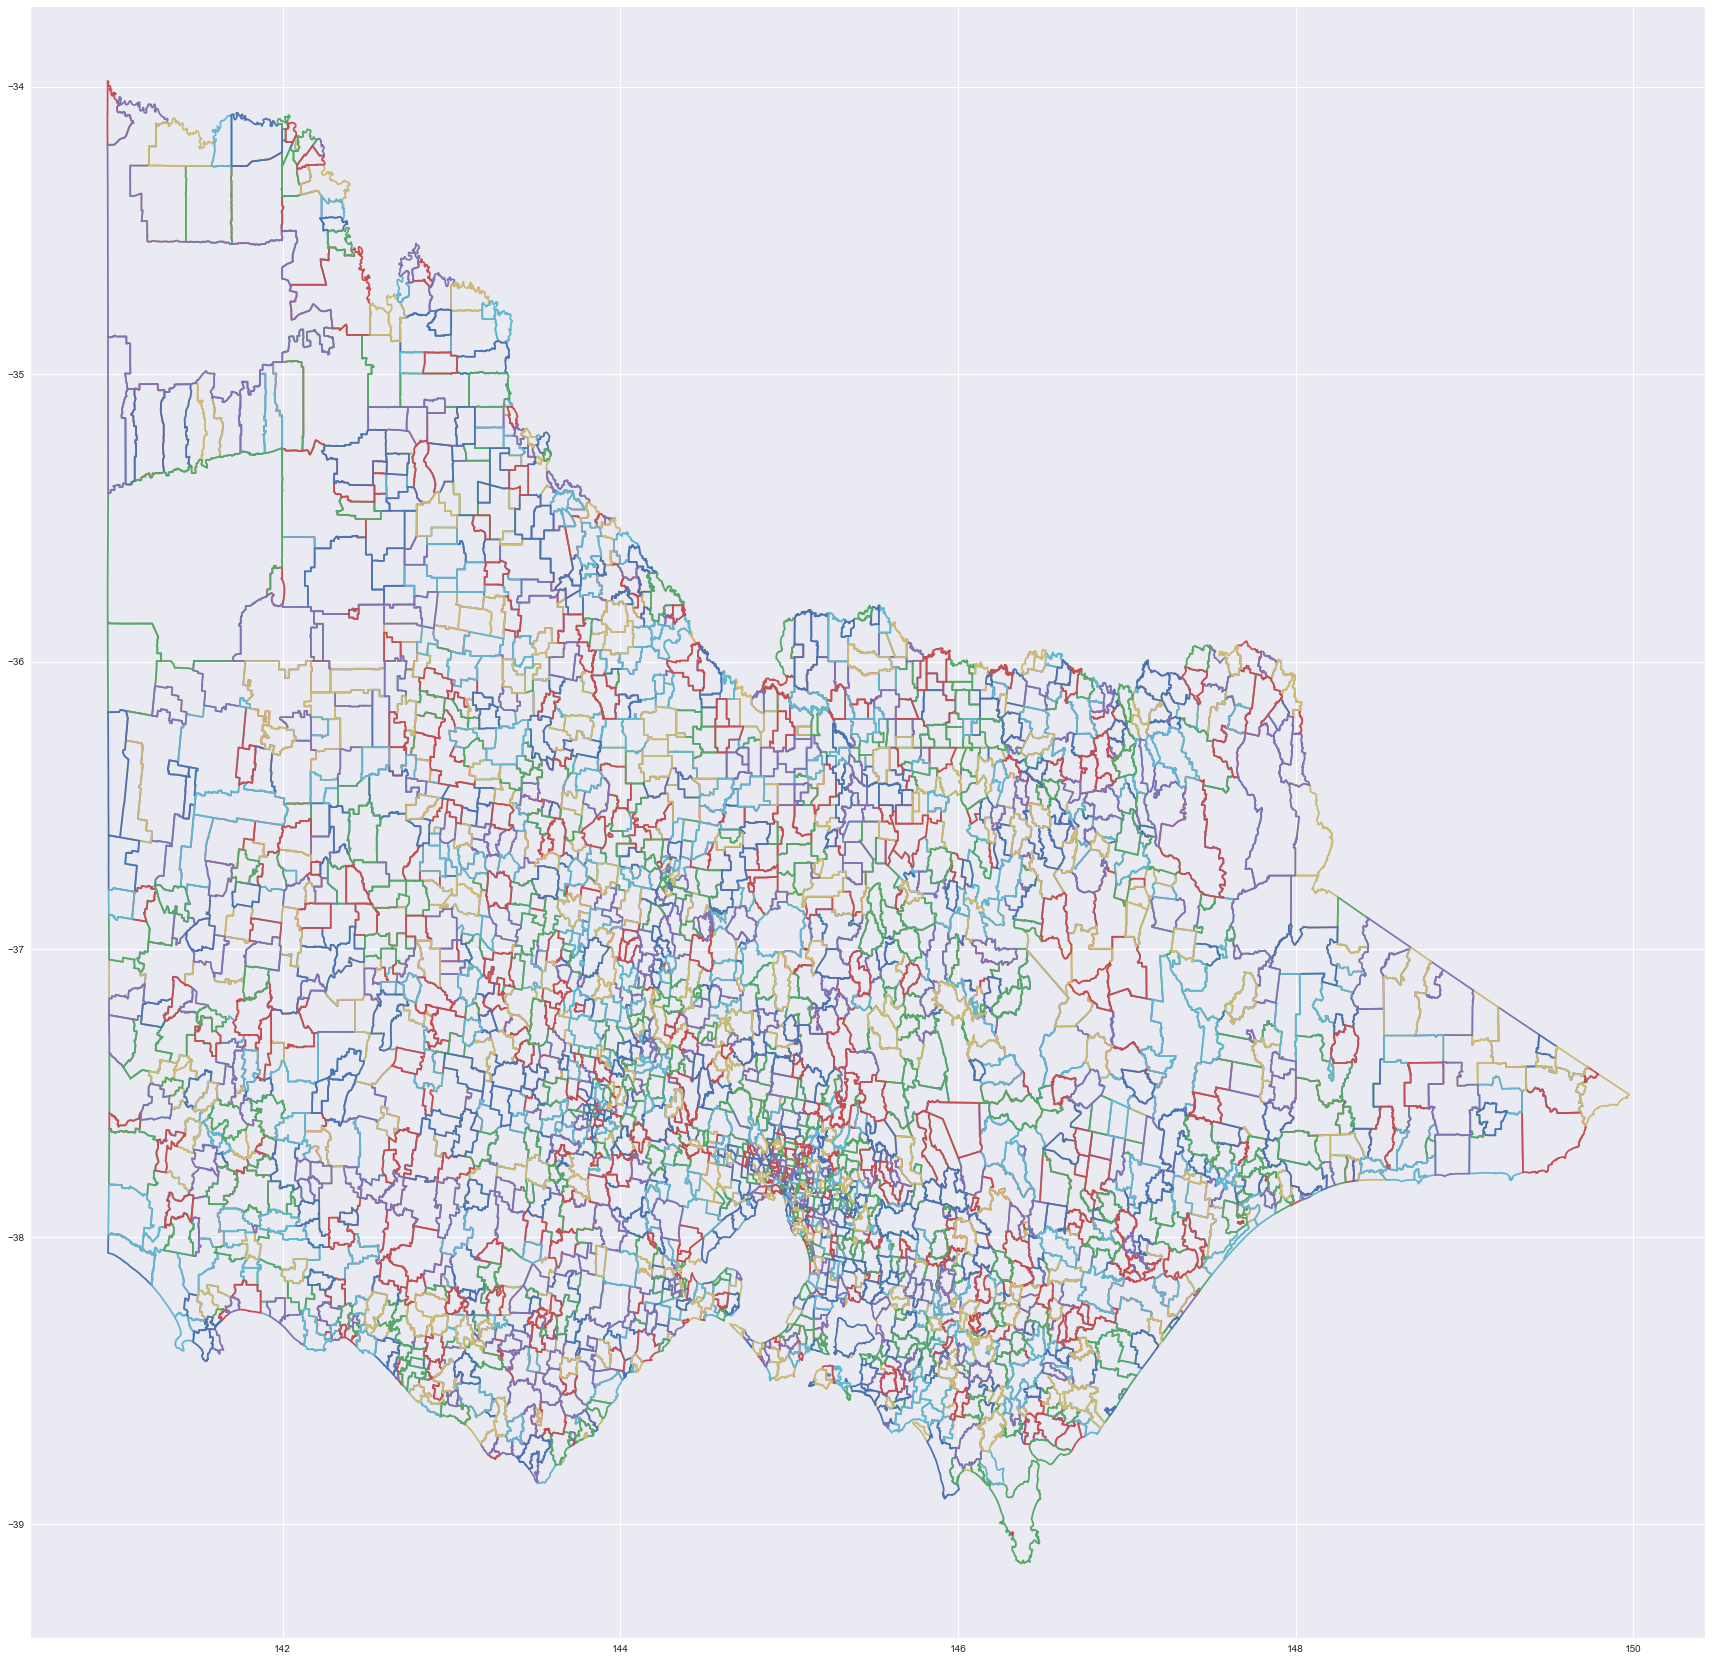

In [37]:
plt.figure(figsize=(30,30))
for shape in sf.shapeRecords():
    
    # end index of each components of map
    l = shape.shape.parts
    
    len_l = len(l)  # how many parts of countries i.e. land and islands
    x = [i[0] for i in shape.shape.points[:]] # list of latitude
    y = [i[1] for i in shape.shape.points[:]] # list of longitude
    l.append(len(x)) # ensure the closure of the last component
    for k in range(len_l):
        # draw each component of map.
        # l[k] to l[k + 1] is the range of points that make this component
        plt.plot(x[l[k]:l[k + 1]],y[l[k]:l[k + 1]])

# display
plt.show()

Each suburb of Victoria now is shown, however, due to the Victoria is very big area, it is quite difficult to see the shape of each suburb clearly.


The next following script will form a list of Polygons object, each polygon consist of a list of latitude and longitude, and use of list of Polygon objects to verify whether the given latitude and longitude of each estate belong to a Polygon or not.

In [38]:
from shapely.geometry import Point, Polygon

# list of Polygon, each Polygon is form of a list of latitude and longitude
polys = [Polygon(shapes[i].points) for i in range(num_of_shape)]

#function to determine suburb of each estate
def finding_suburb(lat,lng):
    """
    This function use to determine the suburb of the given latitude and longitude
    :param: 
        lat: latitude of the estate
        lng: longitude of the estate
    :return:
        suburb name
    """
    #Form a latitude and longitude an object Point
    point = Point(lng,lat)
    
    #loop through the list of polygon
    for i in range(num_of_shape):
        #check whether the point belong to polygon or not
        #if it is
        if polys[i].contains(point):
            #get the suburb from shapes_detail and return the suburb's name
            suburb = shapes_detail[i][6]
            return suburb
    return None
    

In [39]:
# finding the suburb for each estate
results = df_estate.apply(lambda x: finding_suburb(x[1],x[2]),axis=1)
df_estate['suburb'] = list(results)

In [40]:
df_estate

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,shopping_center_id,distance_to_sc,hospital_id,distance_to_hospital,supermarket_id,distance_to_supermaket,suburb
0,5557.0,-37.790287,144.851058,18 Arthur Street,3910000.0,house,2013.0,3.0,1.0,1.0,SC_043,993.019997,hospital_174,2150.536317,S_149,993.146186,BRAYBROOK
1,79731.0,-37.997261,145.149779,16 Emmaline Crescent,6200000.0,house,2012.0,3.0,2.0,2.0,SC_057,2126.965092,hospital_096,1905.576092,S_079,2043.368158,KEYSBOROUGH
2,6281.0,-37.789166,144.842816,17 Union Street,6960000.0,house,2010.0,3.0,1.0,2.0,SC_102,1113.894691,hospital_174,1565.728462,S_080,1197.646429,SUNSHINE
3,31038.0,-37.758343,145.021371,269 Mansfield Street,7950000.0,house,2016.0,4.0,1.0,0.0,SC_001,2089.071211,hospital_039,999.182042,S_105,1758.714155,THORNBURY
4,21307.0,-37.765106,144.964796,5 Edmends Street,14560000.0,house,2014.0,2.0,1.0,1.0,SC_030,3862.333317,hospital_144,1140.936477,S_074,671.657531,BRUNSWICK
5,56807.0,-37.848610,145.109491,6 Elgar Road,4995000.0,house,2016.0,3.0,1.0,2.0,SC_037,3482.000264,hospital_089,1667.150111,S_097,2237.414747,BURWOOD
6,86453.0,-37.911141,144.989884,27 Normanby Street,6303000.0,house,2013.0,4.0,2.0,3.0,SC_015,4793.904446,hospital_198,50.458930,S_150,422.278396,BRIGHTON
7,7690.0,-37.776264,144.799805,1 Glinden Avenue,4680000.0,house,2011.0,3.0,1.0,1.0,SC_102,3046.624464,hospital_057,2180.582037,S_159,2165.127551,ARDEER
8,89501.0,-37.948786,145.015447,39 Hobson Street,9630000.0,house,2014.0,3.0,2.0,2.0,SC_079,2249.662055,hospital_036,1249.570566,S_214,696.344140,SANDRINGHAM
9,33372.0,-37.696310,145.021222,1 Keon Parade,5040000.0,house,2014.0,4.0,2.0,1.0,SC_047,4769.779882,hospital_025,3004.366386,S_228,2648.212085,RESERVOIR


By now, we are already have pretty much everything of the schema, only train station left. 

In the next section, we are going to get the closest station from a particular estate. With the station id, we are required to calculate the average minutes of traveling from that station to the flinder street on weekdays from 7am to 9am.

Let's jump into section 4

## 4. Integrating GTFS Datasets.

About GTFS (General Transit Feed Specification) is a common format for public transportation schedules and associated geographic information. GTFS "feeds" allow public transit agencies to publish their transit data and developers to use that data to write applications. The feeds are represented in a series of text files and include information such as fixed-route schedules, routes, and bus stop data. 

Following are descriptions of the tables required for a valid GTFS data feed. Each table is literally a text CSV file whose filename is the name of the table, suffixed by '.txt'. So for the 'agency' table below, a CSV file called 'agency.txt' would be included in a valid GTFS feed. 

```
Mandatory tables:

1. agency
The agency table provides information about the transit agency as such, including name, website and contact information. 
    agency_id: id of agency
    agency_name: name of agency
    agency_url: website of agency
    agency_timezone: timezone of agency
    agency_lang: language of agency

2. routes
The routes table identifies distinct routes. This is to be distinguished from distinct routings, several of which may belong to a single route. 
    route_id (primary key): self-explained
    agency_id: self-explained
    route_short_name: short name of the route
    route_long_name: full name of the rout
    route_type:
    
3. trips
    trip_id (primary key): self-explained
    route_id (foreign key): self-explained
    service_id (foreign key): self-explained
    shape_id:
    trip_headsign: determine where the trip is heading to
    direction_id:

4. stop_times
    trip_id (foreign key): self-explained
    arrival_time: time when a train come
    departure_time: time when a train leave
    stop_id (foregin key): self-explained
    stop_sequence
    stop_headsign
    pickup_type
    drop_off_type
    shape_dist_traveled
    
5. stops
The stops table defines the geographic locations of each and every actual stop or station in the transit system as well as, and optionally, some of the amenities associated with those stops. 
    stop_id (primary key): self-explained
    stop_name: name of train station
    stop_short_name: short name of train station
    stop_lat: latitude of the train station
    stop_lon: longitude of the train station

6. calendar
The calendar table defines service patterns that operate recurrently such as, for example, every weekday. Service patterns that don't repeat such as for a one-time special event will be defined in the calendar_dates table. 
    service_id (primary key): self-explained
    monday: 0 mean this train is not available on monday, if available then 1
    tuesday: 0 mean this train is not available on tuesday, if available then 1
    wednesday: 0 mean this train is not available on wednesday, if available then 1
    thursday: 0 mean this train is not available on thursday, if available then 1
    friday: 0 mean this train is not available on friday, if available then 1
    saturday: 0 mean this train is not available on saturday, if available then 1
    sunday: 0 mean this train is not available on sunday, if available then 1
    start_date
    end_date
```

More information about GTFS:

https://en.wikipedia.org/wiki/General_Transit_Feed_Specification

https://www.transitwiki.org/TransitWiki/index.php/General_Transit_Feed_Specification


Let's load the data first


In [41]:
df_calendar = pd.read_table('GTFS_Melbourne_Train_Information/calendar.txt',sep=',')
df_routes = pd.read_table('GTFS_Melbourne_Train_Information/routes.txt', sep=',')
df_stop_times = pd.read_table('GTFS_Melbourne_Train_Information/stop_times.txt',sep=',')
df_stop = pd.read_table('GTFS_Melbourne_Train_Information/stops.txt',sep=',')
df_trips = pd.read_table('GTFS_Melbourne_Train_Information/trips.txt',sep=',')

The stops table defines the geographic locations of each and every actual stop or station in the transit system. It contains basic information such as latitude and longitude of station, therefore, we are going to use this table to get nearest station for each estate.

The function get_nearest_facilities defined above is pretty similar to the function we use above to get the closest facilities for estate, just a slightly difference when it will return a tuple of the id of closest station and the distance from a estate to that station

In [42]:
def get_nearest_station(lat,lng, df_facilities):
    df_fa_lat_lng = df_facilities[['stop_lat','stop_lon']]
    value = df_fa_lat_lng.apply(lambda x: distance((lat,lng),(x[0],x[1])),axis=1)
    value = np.asarray(value)
    return (df_facilities.iloc[value.argmin()][0],value.min())


In [43]:
results = df_estate.apply(lambda x: get_nearest_station(x[1],x[2],df_stop),axis=1)
df_result = pd.DataFrame(data=list(results),columns=['id','distance'])
df_estate["train_station_id"] = df_result['id']
df_estate['distance_to_train_station'] = df_result['distance']

By now, we are already closest station for each estate, the hardest part is going to calculate the travel minutes from that station to the flinders street during weekdays from 7am to 9am.

First, we are going to extract all the service that available on weekdays (from Monday to Friday) but not available on Saturday and Sunday from df_calendar dataframe

In [44]:
df_calendar = df_calendar[(df_calendar['monday'] == 1) & (df_calendar['tuesday'] == 1) & (df_calendar['wednesday'] == 1) &\
                         (df_calendar['thursday'] == 1) &  (df_calendar['friday'] == 1)]
df_calendar = df_calendar.reset_index().drop(['index'],axis=1)

With all the service_id we've filter above, let's get all the correcsponding trips that running only on weekdays

In [45]:
df_trips = df_trips[df_trips['service_id'].isin(df_calendar['service_id'])]
df_trips = df_trips.reset_index().drop(['index'],axis=1)

Because trip_id is a foregin key of stop_times table, therefore, we will get all the stop_time with the correcsponding trip_id

In [46]:
df_stop_times = df_stop_times[df_stop_times['trip_id'].isin(df_trips['trip_id'])]

Note, from the routes table, we can see that there are some routes that do not head to Flinders Street

In [47]:
df_routes

,route_id,agency_id,route_short_name,route_long_name,route_type
0,2-ALM-B-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
1,2-ALM-C-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
2,2-ALM-D-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
3,2-ALM-E-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
4,2-ALM-F-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
5,2-BEL-B-mjp-1,1,Belgrave,City (Flinders Street) - Belgrave,2
6,2-BEL-C-mjp-1,1,Belgrave,City (Flinders Street) - Belgrave,2
7,2-BEL-D-mjp-1,1,Belgrave,City (Flinders Street) - Belgrave,2
8,2-BEL-E-mjp-1,1,Belgrave,City (Flinders Street) - Belgrave,2
9,2-BEL-F-mjp-1,1,Belgrave,City (Flinders Street) - Belgrave,2


Shall we remove all the routes that do not go to Flinders Street? 

The answers is no, because the routes table defined the starting and ending of station of the routes, thus, when the routes for example the route from City(Flinder Street) - Belgrave. It means that the train also go back from Belgrave to City(Flinder Street) as well.

This rule has been defined in the trips table with the trip_id. 

All the trip_id ends with ".H" mean heading, and all the trip_id ends with ".R" mean return.

For example the trip_id corresponds to the routes: City (Flinders Street) - Belgrave which ends with ".H" mean the train is heading to Belgrave from Flinders Street, and wheh the trip_id correcsponds to that routes ends with ".R" mean the train is return to Flinder Street from Belgrave. 

Now, we will extract all data from stop_times table to get only data of departure_time that happened in proper times (from 7am to 9am)

In [48]:
b_bottom = "07:00:00"
b_up = "09:00:00"
df_departure_stop_times =  df_stop_times[(df_stop_times['departure_time'] >= b_bottom) & \
                                         (df_stop_times['departure_time'] <= b_up)]

The question is: how do we calculate the average minutes from the station to the flinder street.

The idea is very intuitive. If there is a direct train from a station to the flinders street, the trip_id will be similar for each row of data. 

Let's suppose there is a train from Caulfield to Flinders. According to stops table, the station_id of Caulfield is 19943 and the station_id of Flinders Street station is 19854. 

Look into the data to see the trip_id.

In [49]:
df_departure_stop_times[(df_departure_stop_times['stop_id']==19943)]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
77049,17070021.T0.2-CRB-F-mjp-1.2.H,07:02:00,07:02:00,19943,16,NaN,0,0,33248.733232
77072,17070027.T0.2-CRB-F-mjp-1.2.H,07:32:00,07:32:00,19943,16,NaN,0,0,33248.733232
77095,17070024.T0.2-CRB-F-mjp-1.2.H,07:21:00,07:21:00,19943,16,NaN,0,0,33248.733232
77118,17070030.T0.2-CRB-F-mjp-1.2.H,07:46:00,07:46:00,19943,16,NaN,0,0,33248.733232
77141,17070037.T0.2-CRB-F-mjp-1.2.H,08:15:00,08:15:00,19943,16,NaN,0,0,33248.733232
77164,17070033.T0.2-CRB-F-mjp-1.2.H,08:01:00,08:01:00,19943,16,NaN,0,0,33248.733232
77187,17070041.T0.2-CRB-F-mjp-1.2.H,08:34:00,08:34:00,19943,16,NaN,0,0,33248.733232
77210,17070045.T0.2-CRB-F-mjp-1.2.H,08:46:00,08:46:00,19943,16,NaN,0,0,33248.733232
79718,17069351.T0.2-CRB-F-mjp-1.9.R,07:34:00,07:34:00,19943,12,NaN,0,0,14854.646985
79741,17069362.T0.2-CRB-F-mjp-1.9.R,08:11:00,08:11:00,19943,12,NaN,0,0,14854.646985


As we can see, the row of the index = 64887 have the trip_id = 17070021.T0.2-CRB-F-mjp-1.2.H, start at 7:02:00.

Let's see whether the data that have the same trip_id but stop_id equal to 19854

In [50]:
df_departure_stop_times[(df_departure_stop_times['stop_id']==19854) &(df_departure_stop_times['trip_id']=='17070021.T0.2-CRB-F-mjp-1.2.H')]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
77056,17070021.T0.2-CRB-F-mjp-1.2.H,07:26:00,07:26:00,19854,27,NaN,0,0,48011.330925


We do have one data statisfy our assumption.

By using this assumption, in order to calculate for all the stop_station, we first going to get all the dataframe that have only stop_id of Flinders Street (stop_id = 19854). 

For each station_id, we are going to merger a data of each station_id to the data of Flinders Street station_id based on the trip_id. The idea is to get a dataframe of the start station_id with departure time and arrival time when the train arrival to Flinders 

In [51]:
# flinders street station_id
flinder_id = 19854
# a dataframe contain only the trip_id and arrival_time of station_id of Flinders Street
df_flinder_time_arrival = df_stop_times[df_stop_times['stop_id'] == flinder_id][['trip_id','arrival_time']]

# a function to convert string to time
def convert_to_time(time):
    pattern = "%H:%M:%S"
    return datetime.strptime(time,pattern)

# This function is used to calculate the average minutes from each specific station to Flinder Street
def calculate_time(station_id):
    """
    This function is used to calculate the average minutes from each specific station to Flinder Street
    :param:
        station_id: an id of station
    :return:
        average minutes from the station to Flinder Street
    """
    
    # a dataframe that contain trip_id and departure_time of particular station_id
    time_departure = df_departure_stop_times[df_departure_stop_times['stop_id'] == station_id][['trip_id','departure_time']]    
    # a dataframe that merge time_departure to df_flinder_time_arrival based on the trip_id
    df_commute = time_departure.merge(df_flinder_time_arrival,on="trip_id",how="left")
    df_commute = df_commute.dropna()
    # remove all the data which have departure_time that less than arrival_time
    # the reasons because, when the train belong to the route that do not head to Flinder, for example the routes of 
    # City (Flinder Street) to Belgrave. so the departure_time is actually less than arrival_time. 
    # However, when the trip_id end withs ".R" mean it return Flinders from Belgrave, the 'departure_time" is bigger than 
    # the arrival time
    df_commute = df_commute[(df_commute['departure_time'] < df_commute['arrival_time'])]
    df_commute = df_commute.reset_index().drop(['index'],axis=1)
    
    #By now, calculate the average minutes
    depar_time = df_commute['departure_time'].map(lambda x: convert_to_time(x))
    arr_time = df_commute['arrival_time'].map(lambda x: convert_to_time(x))
    df_commute['minutes'] = (arr_time - depar_time).map(lambda x: (x.seconds)/60)
    mean = df_commute['minutes'].mean()
    return mean

Now, get the travel min to CBD

In [52]:
df_estate['travel_min_to_CBD'] = df_estate['train_station_id'].map(lambda x: calculate_time(x))

In [53]:
df_estate[df_estate['travel_min_to_CBD'].isnull()]

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,shopping_center_id,distance_to_sc,hospital_id,distance_to_hospital,supermarket_id,distance_to_supermaket,suburb,train_station_id,distance_to_train_station,travel_min_to_CBD
92,2156.0,-37.777760,144.881954,31 Wattle Road,10640000.0,house,2013.0,3.0,2.0,1.0,SC_052,649.531912,hospital_003,1729.993306,S_049,817.432651,MAIDSTONE,20027,2488.192750,NaN
978,81.0,-37.828915,144.961021,94 Moray Street,10336000.0,house,2014.0,1.0,2.0,2.0,SC_101,386.958070,hospital_135,194.637796,S_016,380.571549,SOUTHBANK,19854,1291.514013,NaN
1135,11364.0,-37.774500,144.880615,31 Cavalry Circuit,6120000.0,house,2012.0,2.0,1.0,1.0,SC_052,494.733710,hospital_003,2110.979292,S_049,772.267032,MARIBYRNONG,20027,2762.448791,NaN


For the train station id is 19854, the accomodation is near flinder street, so the travel minutes to CBD will be 0 and transfer flag will be 0.

Let's see what happend with the train_station id of 20027. We will load the data of stop_times again to see

In [54]:
h = pd.read_table("GTFS_Melbourne_Train_Information/stop_times.txt",sep=",")
h[h['stop_id'] == 20027]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
390202,17199141.T2.2-ain-mjp-1.2.H,18:13:00,18:13:00,20027,7,NaN,0,0,8069.390923
390303,17199142.T2.2-ain-mjp-1.5.R,24:00:00,24:00:00,20027,1,NaN,0,0,0.000000


as we can see, there are two records invole to have stop_id equal 20027, however, it does not happen in the specify time period ( 7 to 9 am from Monday to Friday ). 

For this case, we will get the second closest station that has the trip to Flinder Street. Before that, let change the value of travel_min_to_CBD of Flinders Street id to 0

In [55]:
df_estate.loc[df_estate['train_station_id'] == 19854,'travel_min_to_CBD'] = 0

In [56]:
def second_closest_station(lat,lng, df_facilities):
    df_fa_lat_lng = df_facilities[['stop_lat','stop_lon']]
    value = []
    value = df_fa_lat_lng.apply(lambda x: distance((lat,lng),(x[0],x[1])),axis=1)
    value = np.asarray(value)
    v = np.amin(value[value != np.amin(value)])
    index = value.tolist().index(v)
    return (df_facilities.iloc[index][0],round(v,3))

results = df_estate[df_estate['travel_min_to_CBD'].isnull()].apply(lambda x: second_closest_station(x[1],x[2],df_stop),axis=1)
df_result = pd.DataFrame(data=list(results),columns=['id','distance'])
df_result['distance'] = df_result['distance']
df_estate.loc[df_estate['travel_min_to_CBD'].isnull(),'train_station_id'] = list(df_result['id'])
df_estate.loc[df_estate['travel_min_to_CBD'].isnull(),'distance_to_train_station'] = list(df_result['distance'])

Calculate the average minutes for the new station_id

In [57]:
df_estate.loc[df_estate['travel_min_to_CBD'].isnull(),'travel_min_to_CBD'] \
        = df_estate[df_estate['travel_min_to_CBD'].isnull()]['train_station_id'].map(lambda x: calculate_time(x))

In [58]:
df_estate['transfer_flag'] = 0
df_estate.loc[df_estate['travel_min_to_CBD'].isnull(),'transfer_flag'] = 1

Now, we are going to produce the file in csv format. Before that, let's convert the data to the right format from the sample  file

In [59]:
df_estate['property_id'] = df_estate['property_id'].astype(np.int64)
df_estate['lat'] = df_estate['lat'].astype(np.float64)
df_estate['lng'] = df_estate['lng'].astype(np.float64)
df_estate['price'] = df_estate['price'].astype(np.int64)
df_estate['year'] = df_estate['year'].astype(np.int64)
df_estate['bathrooms'] = df_estate['bathrooms'].astype(np.int64)
df_estate['bedrooms'] = df_estate['bedrooms'].astype(np.int64)
df_estate['parking_space'] = df_estate['parking_space'].astype(np.int64)
df_estate['distance_to_sc'] = df_estate['distance_to_sc'].astype(np.int64)
df_estate['train_station_id'] = df_estate['train_station_id'].astype(np.int64)
df_estate['distance_to_train_station'] = df_estate['distance_to_train_station'].astype(np.int64)
df_estate['travel_min_to_CBD'] = df_estate['travel_min_to_CBD'].astype(np.int64)
df_estate['transfer_flag'] = df_estate['transfer_flag'].astype(np.int64)
df_estate['distance_to_hospital'] = df_estate['distance_to_hospital'].astype(np.int64)
df_estate['distance_to_supermaket'] = df_estate['distance_to_supermaket'].astype(np.int64)

#Change the Suburb name to title case
df_estate['suburb'] = df_estate['suburb'].map(lambda x : x.str.title())

Re-arragne the order of columns

In [60]:
columns = ["property_id","lat","lng","addr_street","suburb","price","property_type","year","bedrooms","bathrooms",\
           "parking_space","shopping_center_id","distance_to_sc","train_station_id","distance_to_train_station",\
          "travel_min_to_CBD","transfer_flag","hospital_id","distance_to_hospital","supermarket_id","distance_to_supermaket"]
df_estate = df_estate.reindex(columns=columns)

Now, produce the data

In [66]:
df_estate.to_csv("solution.csv")

We are done with the task 1, let's move to the task 2

# Task 2: Data Reshaping

In this task, we are going to study the effect of different normalization/transformation methods (i.e. standardization, minmax normalization, log, power, and sqrt transformation) on the "price" and also explain their effect on the price distribution.

Compare the price from different normalization/transformation techniques by assuming "bedrooms", "bathrooms", "parking_space" and "property_type" are predictors of the linear model. 

Finally, recommend which one(s) is better on this data.

First, let's copy the original data to another variable

In [62]:
df_tf = df_estate.copy()

We only consider to the "bedrooms", "bathrooms", "parking_space", "property_type" and "price", thus, we will filter out the data to get a new dataframe which have only those variable

In [63]:
df_tf = df_tf[['property_type','bedrooms','bathrooms','parking_space','price']]

In [64]:
df_tf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 5 columns):
property_type    1971 non-null object
bedrooms         1971 non-null int64
bathrooms        1971 non-null int64
parking_space    1971 non-null int64
price            1971 non-null int64
dtypes: int64(4), object(1)
memory usage: 77.1+ KB


Let's see how many type of property

In [65]:
df_tf['property_type'].unique()

array(['house'], dtype=object)

There are only one type (house) from given data, therefore, we can safety remove "property_type" feature

In [66]:
df_tf.drop(['property_type'],axis=1,inplace=True)

All the features are categorical, let's see how many value for each those features.

In [67]:
print("Bathrooms: ",df_tf['bathrooms'].unique())
print("Bedrooms:",df_tf['bedrooms'].unique())
print("Parking_space:", df_tf['parking_space'].unique())

Bathrooms:  [1 2 3]
Bedrooms: [3 4 2 5 1]
Parking_space: [1 2 0 3]


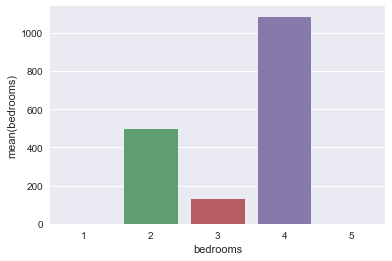

In [68]:
sns.barplot(x = 'bedrooms', y = df_tf['bedrooms'].value_counts(), data = df_tf, ci = None)

Most of the estate have 2,3 and 4 bedrooms instead of 1 or 5.

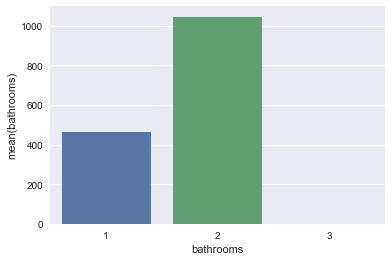

In [69]:
sns.barplot(x = 'bathrooms', y = df_tf['bathrooms'].value_counts(), data = df_tf, ci = None)

It is rarely to see a estate that have 3 bathrooms

Let's the number of bathrooms versus bedrooms

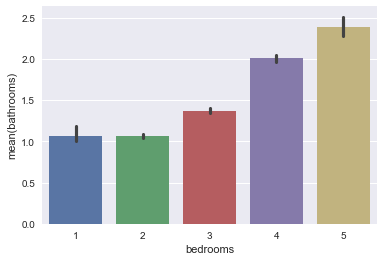

In [70]:
sns.barplot(x="bedrooms", y="bathrooms", data=df_tf)

Before going into to choose the features that best-fit for price using linear model, we are going to see the effect of different techniques of normalization/transformation on price.

## 1. Scaling

Feature scaling can vary your results a lot while using certain algorithms and have a minimal or no effect in others. From the data, price is very highly varying in comparison to the bathrooms, bedrooms and parking_space. Therefore, we will look in some techniques of scaling data to see the different.


First, let's see the distribution of the orginal price

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


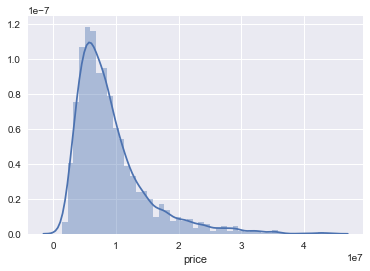

In [71]:
sns.distplot(df_tf['price'])

It can be seen that the price is strongly left skews. 

In the next following section, we are going to see the change of the distrituion of price when we apply some different techniques of normalization/transformation.

### 1.1 Min-max Scaling

The idea behind min-max scaling is data can be fitted within a specific scale, like 0-100 or 0-1. This technique is crucial when we want to apply some machine learning algorithms that based on measure how far apart data points, such as Suport Vector Machine (SVM) or k-nearest neighbors or KNN.

Formula for min-max scaling: 


<font size=6> $x_{new} = \frac{x_{original} - x_{min}} {x_{max} - x_{min}} $ </font>


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The '

Text(0.5,1,'Min-max scaling data')

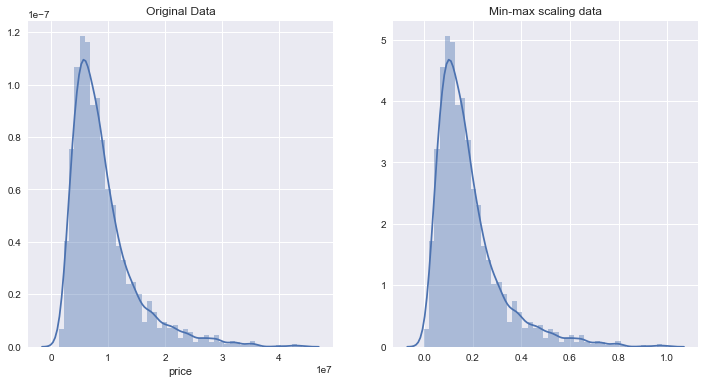

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mmax_scaler = MinMaxScaler()
min_max_price = mmax_scaler.fit_transform(df_tf['price'])

# plot both together to compare
fig, ax=plt.subplots(1,2, figsize=(12,6))
sns.distplot(df_tf['price'], ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(min_max_price, ax=ax[1])
ax[1].set_title("Min-max scaling data")


Although, the shape of distribution does not change, however, we can see that the data now reduce to the range from 0 - 1. Even though, min-max technique actually remove all outlier (if there are). If we want to observe the outlier, min-max technique probably is not a good choice.

### 1.2 Standardization.

Or well know as a z-score transformation. This technique converts all indicators to a common scale with an average of zero and standard deviation of one.

Formula for min-max scaling: 


<font size=6> $z_{i} = \frac{x_{i} - \bar{x}} {s} $ </font>

Where:
* xi is a data point (x1, x2…xn).
* x̄ is the sample mean.
* s is the sample standard deviation.


In [ ]:
from sklearn.preprocessing import StandardScaler
zscore_scaler = StandardScaler()
zscore_price = zscore_scaler.fit_transform(df_tf['price'])
# plot both together to compare
fig, ax=plt.subplots(1,2,figsize=(12,6))
sns.distplot(df_tf['price'], ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(zscore_price, ax=ax[1])
ax[1].set_title("Z_Score scaling data")


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The

Text(0.5,1,'Z_Score scaling data')

It seems like the shape of data does not change much even when we apply z-score transformation. Notice that the range of price now is from -2 to bigger than 6. 

## 2. Transformation.

Scaling just changes the range of your data. Normalization is a more radical transformation. The point of normalization is to change your observations so that they can be described as a normal distribution.

In general, you'll only want to normalize your data if you're going to be using a machine learning or statistics technique that assumes your data is normally distributed. Some examples of these include t-tests, ANOVAs, linear regression, linear discriminant analysis (LDA) and Gaussian naive Bayes.

Let's apply the different method of transformation on price.

### 2.1 Cube Root Transformation.

The cube root transformation involves converting x to $x^\frac{1}{3}$. This is a fairly strong transformation with a substantial effect on distribution shape: but is weaker than the logarithm. It can be applied to negative and zero values too. Negatively skewed data.

In [ ]:
cube_root_price = df_tf['price'].map(lambda x: x**(1/3))
fig, ax=plt.subplots(1,2,figsize=(12,6))
sns.distplot(df_tf['price'], ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(cube_root_price, ax=ax[1])
ax[1].set_title("Cube root transformation data")

The shape look more normal distribution than the scaling technique. 

Let's see how the data change when using square and log transformation.

### 2.2 Power Transformation.

In [ ]:
square_2_price = df_tf['price'].map(lambda x: x**2)
fig, ax=plt.subplots(1,2,figsize=(12,6))
sns.distplot(df_tf['price'], ax=ax[0])
ax[0].set_title("Original Price")
sns.distplot(square_2_price, ax=ax[1])
ax[1].set_title("Square Transformation")

Pow transformation even make the distribution more left skew than the original data

### 2.2 Square Root versus Log Transformation

In [ ]:
square_root_price = df_tf['price'].map(lambda x: np.sqrt(x))
log_price = np.log10(df_tf['price'])

fig, ax=plt.subplots(1,2,figsize=(12,6))
sns.distplot(square_root_price, ax=ax[0])
ax[0].set_title("Square Root Price")
sns.distplot(log_price, ax=ax[1])
ax[1].set_title("Log Price")

Apparently, log transformation on price give more normal distribution than square root technique or cube root technique. Using log transformation on price make a shape nearly normal. This is crucial if we want to infer more from data as most of the statistic methods such as hypothesis testing prefer to see normal distribution. 

## 3. Building a Linear Model.

From the previous section, we've seen how the different techniques impact on the price and we also explain when and where to use, also mention to the advantages and disadvantages of those technique.

In this section, we will try to attempt to build a linear model based on the "bedrooms", "bathrooms", "parking_space" for predicting house price. Those feature will be taken into consideration against the different prices that we have from previous section.

First, let's see how the correlation between those features to the original price

In [ ]:
df_corr = df_tf.corr()
f, ax = plt.subplots(figsize=(8,6))
sns.set(font_scale=1.25)
sns.heatmap(df_corr, vmax=.8, square=True,annot=True,annot_kws={'size': 16});

Bedrooms and bathrooms seem to have high correlation with the price.

Let's try with the other scaling/nomarlization we've been done above

In [ ]:
df_tf['min_max_price'] = min_max_price
df_tf['zscore_price'] = zscore_price
df_tf['cube_price'] = cube_root_price
df_tf['square_root_price'] = square_root_price
df_tf['log_price'] = log_price
df_tf['power_price'] = square_2_price

df_corr = df_tf.corr()
f, ax = plt.subplots(figsize=(12,10))
sns.set(font_scale=1.25)
sns.heatmap(df_corr, vmax=.8, square=True,annot=True,annot_kws={'size': 16});

Interestingly, the correlation between bedrooms, bathrooms, parking_space with the scaling method ( min_max, z-score ) do not change while the number of correlation for transformation methods (cube_root, square and log) slightly decrease even the log transformation gave price a nearly normal distribution shape.

It seem reasonable when bedrooms, bathrooms and parking_space are categorical instead of continuous number.

Let's do some feature engineering to see if they effect to the price.

In [ ]:
df_fe = pd.DataFrame()

# Apply square to all three features
df_fe['bathrooms'] = np.square(df_tf['bathrooms'])
df_fe['bedrooms'] = np.square(df_tf['bedrooms'])
df_fe['parking_space'] = np.square(df_tf['parking_space'])

# sum bedrooms, bathrooms and parking_space up
df_fe['sum_bbp'] = df_fe['bedrooms'] + df_fe['bathrooms'] + df_fe['parking_space']
df_fe['price'] = df_tf['price']
df_fe['min_max_price'] = df_tf['min_max_price']
df_fe['zscore_price'] = df_tf['zscore_price']
df_fe['cube_price'] = df_tf['cube_price']
df_fe['square_root_price'] = df_tf['square_root_price']
df_fe['log_price'] = df_tf['log_price']
df_fe['power_price'] = df_tf['power_price']

# df_corr
df_corr = df_fe.corr()
f, ax = plt.subplots(figsize=(12,10))
sns.set(font_scale=1.25)
sns.heatmap(df_corr, vmax=.8, square=True,annot=True,annot_kws={'size': 16})

As we can see, the parking_space is less effect to the price. 

Let's see the classification

In [ ]:
# number of bedrooms versus bathrooms
sns.lmplot(y='price',x='bedrooms',col='bathrooms',data=df_tf,fit_reg=False)

In [ ]:
# number of bedrooms versus parking_space
sns.lmplot(y='price',x='bedrooms',col='parking_space',data=df_tf,fit_reg=False)

In [ ]:
# number of bathrooms versus parking_space
sns.lmplot(y='price',x='bathrooms',col='parking_space',data=df_tf,fit_reg=False)

One thing we can note from the graph above is, all the estate that happened to have 3 bedrooms is always have more than 3 bathrooms. On the other hand, it is rarely too see the estate that have 5 bedrooms but only 1 bathrooms and only one estate have 1 bedrooms but have 2 bathrooms.


Now, we will try to build a linear model to see what is normalization/transformation methods that give the high r_square.

First, let's try if we apply square to number of bathrooms, bedrooms and parking space

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score

methods = ["price","min_max_price","zscore_price","cube_price","square_root_price","log_price","power_price"]

df_fe = pd.DataFrame()
# different price from transformation
df_fe['price'] = df_tf['price']
df_fe['min_max_price'] = df_tf['min_max_price']
df_fe['zscore_price'] = df_tf['zscore_price']
df_fe['cube_price'] = df_tf['cube_price']
df_fe['square_root_price'] = df_tf['square_root_price']
df_fe['log_price'] = df_tf['log_price']
df_fe['power_price'] = df_tf['power_price']

def best_method(df_fe):
    r_square = 0
    method = None
    index = 0
    for technique in methods:
        for i in range(2000):
            X_train, X_test, y_train, y_test = train_test_split(df_fe[['bathrooms','bedrooms','parking_space']], \
                                                                df_fe[[technique]], random_state=i)
            lm = LinearRegression()
            lm.fit(X_train,y_train)
            r = lm.score(X_test,y_test)
            if r > r_square:
                r_square = r
                method = technique
                index = i
    print(method,"give best r_square:",r_square)

In [ ]:
df_fe['bathrooms'] = (df_tf['bathrooms'])
df_fe['bedrooms'] = (df_tf['bedrooms'])
df_fe['parking_space'] = (df_tf['parking_space'])
best_method(df_fe)

If we do not apply any transformation or normalization technique on price, the best r_square come from min_max transformation method on price, which is 0.146

In [ ]:
df_fe['bathrooms'] = mmax_scaler.transform(df_tf['bathrooms'])
df_fe['bedrooms'] = mmax_scaler.transform(df_tf['bedrooms'])
df_fe['parking_space'] = mmax_scaler.transform(df_tf['parking_space'])
best_method(df_fe)

The same score witness if we apply min_max on predictors

In [ ]:
df_fe['bathrooms'] = np.square(df_tf['bathrooms'])
df_fe['bedrooms'] = np.square(df_tf['bedrooms'])
df_fe['parking_space'] = np.square(df_tf['parking_space'])
best_method(df_fe)

So, if we square the features of bathrooms, bedrooms and parking_space, the power transformation on price gives the best r_square, which is 0.16

In [ ]:
df_fe['bathrooms'] = np.power(df_tf['bathrooms'],4)
df_fe['bedrooms'] = np.power(df_tf['bedrooms'],4)
df_fe['parking_space'] = np.power(df_tf['parking_space'],4)
best_method(df_fe)

If we transform bedrooms, bathroom and parking_space to power of 4, power transformation method on price gives the best r_square, which is 0.1883

Let's see what is r_square if we use only bedrooms and bathrooms as a predictors

In [ ]:
def best_method_2(df_fe):
    r_square = 0
    method = None
    index = 0
    for technique in methods:
        for i in range(2000):
            X_train, X_test, y_train, y_test = train_test_split(df_fe[['bathrooms','bedrooms']], \
                                                                df_fe[[technique]], random_state=i)
            lm = LinearRegression()
            lm.fit(X_train,y_train)
            r = lm.score(X_test,y_test)
            if r > r_square:
                r_square = r
                method = technique
                index = i
    print(method,"give best r_square:",r_square)
    
df_fe['bathrooms'] = np.power(df_tf['bathrooms'],4)
df_fe['bedrooms'] = np.power(df_tf['bedrooms'],4)
best_method_2(df_fe)

Apparently, only use bedrooms and bathrooms as predictors give higher r_square score than using 3 predictors

## 4. Conclusion

From all the normalization/transformation methods above, it seem like we get a better linear model if we apply power transformation on price and apply power transformation on bedrooms, bathrooms and parking_space. Also, parking_space have very less effect to the price, so we actually can build a linear model based on bedrooms and bathrooms.